In [101]:
import pandas as pd
from statistics import mean, stdev 

In [102]:
merchant_train = pd.read_csv('../data/curated/final_model/agg_fortnightly_mean_sd_marketcorr_train_NOFRAUD.csv')
merchant_validate = pd.read_csv('../data/curated/final_model/agg_fortnightly_mean_sd_marketcorr_validate_NOFRAUD.csv')
merchant_overall = pd.read_csv('../data/curated/final_model/agg_fortnightly_mean_sd_marketcorr_NOFRAUD.csv')

merchant_fortnight_train = pd.read_csv('../data/curated/final_model/fortnightly_agg_merchant_transactions_train_NOFRAUD.csv')
merchant_fortnight_validate = pd.read_csv('../data/curated/final_model/fortnightly_agg_merchant_transactions_validate_NOFRAUD.csv')
merchant_fortnight= pd.read_csv('../data/curated/final_model/fortnightly_agg_merchant_transactions_NOFRAUD.csv')

In [103]:
growth = pd.read_csv('../data/curated/final_model/E(r)_final.csv')

In [104]:
merchant_train = merchant_train.merge(growth, on='merchant_abn', how='inner')
merchant_train

,merchant_abn,mean,stdev,n_periods,corr,covar,beta,weighted E(r)
0,10023283211,70749.673866,18636.265281,23,0.924841,2.089959e+11,0.001421,-0.506826
1,10142254217,22397.234199,7661.654456,23,0.848513,7.883019e+10,0.000536,-0.523320
2,10187291046,6739.845784,3296.685077,23,0.356489,1.425068e+10,0.000097,-0.374233
3,10192359162,41976.201423,19772.703184,23,0.503911,1.208179e+11,0.000822,-0.539180
4,10206519221,90606.920640,25122.144347,23,0.945070,2.878939e+11,0.001958,-0.506193
...,...,...,...,...,...,...,...,...
4348,99938978285,106653.055688,25983.036269,23,0.978122,3.081731e+11,0.002096,-0.539419
4349,99974311662,6155.721098,3952.631998,23,0.301563,1.445361e+10,0.000098,-0.393847
4350,99976658299,877875.375777,223217.077839,23,0.983820,2.662900e+12,0.018111,-0.531831
4351,99987905597,13342.109019,7503.391891,23,0.349577,3.180625e+10,0.000216,-0.357825


first write function that gets scores of all stores

In [105]:
merchant_overall = merchant_overall.fillna(0)
merchant_train = merchant_train.fillna(0)
merchant_validate = merchant_validate.fillna(0)

a_combo = [1, 1, 1, 1]

def get_hscore(merchant_train, a_combo, k):
    VARNAME = ['mean', 'stdev', 'corr', 'weighted E(r)']

    merchant_train['score'] = a_combo[0] * merchant_train[VARNAME[0]]

    for i in range(1, k):
        merchant_train['score'] = merchant_train['score'] + a_combo[i] * merchant_train[VARNAME[i]]
    
    return merchant_train[['merchant_abn', 'score']]

In [106]:
# testrun
merchants_train_score = get_hscore(merchant_train, a_combo, 3)
merchants_train_score

,merchant_abn,score
0,10023283211,8.938686e+04
1,10142254217,3.005974e+04
2,10187291046,1.003689e+04
3,10192359162,6.174941e+04
4,10206519221,1.157300e+05
...,...,...
4348,99938978285,1.326371e+05
4349,99974311662,1.010865e+04
4350,99976658299,1.101093e+06
4351,99987905597,2.084585e+04


get top 100 and make into portfolio (just a list)

In [107]:
def get_portfolio_abn(merchants_train_score):
    sorted_merchants_train_score = merchants_train_score.sort_values(['score'], ascending=False)

    top_100_portfolio = sorted_merchants_train_score.head(100)

    top_portfolio_merchants = list(top_100_portfolio['merchant_abn'])

    return top_portfolio_merchants


In [108]:
top_portfolio_merchants = get_portfolio_abn(merchants_train_score)

Get Portfolio Stats (load periodic data and add up)
-own fortnightly E[r] and sd(r)
-calculate E(r) / sd(r)

In [109]:
def get_sharpe_ratio_of_portfolio(merchant_fortnight_validate, top_portfolio_merchants):
    top_100_portfolio_fortnightly = pd.DataFrame()

    for abn in top_portfolio_merchants:
        tmp = merchant_fortnight_validate[merchant_fortnight_validate['merchant_abn'] == abn]
        top_100_portfolio_fortnightly = pd.concat([top_100_portfolio_fortnightly, tmp])

    top_100_portfolio_fortnightly_agg = top_100_portfolio_fortnightly.groupby(['Year', 'Fortnight']).agg({'sum_transactions': mean})

    top_100_portfolio_fortnightly_mean = mean(top_100_portfolio_fortnightly_agg['sum_transactions'])
    top_100_portfolio_fortnightly_sd = stdev(top_100_portfolio_fortnightly_agg['sum_transactions'])

    portfolio_sharpe_ratio = top_100_portfolio_fortnightly_mean/top_100_portfolio_fortnightly_sd
    
    return portfolio_sharpe_ratio

In [110]:
portfolio_sharpe_ratio = get_sharpe_ratio_of_portfolio(merchant_fortnight_validate, top_portfolio_merchants)

In [111]:
portfolio_sharpe_ratio

8.388794805205118

then write loop for alphas

In [112]:
a_combos = []

a_values = [-10000, -100, -10, -1, -0.1, -0.01, -0.001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]

for a1 in a_values:
    # a_combos.append([a1])
    for a2 in a_values:
        # a_combos.append([a1, a2])
        for a3 in a_values:
            a_combos.append([a1, a2, a3])
    #         for a4 in a_values:
    #             a_combos.append([a1, a2, a3, a4])

In [113]:
all_sharpe_ratios = list()


for a_combo in a_combos:
    merchants_train_score = get_hscore(merchant_train, a_combo, 3)

    top_portfolio_merchants = get_portfolio_abn(merchants_train_score)

    portfolio_sharpe_ratio = get_sharpe_ratio_of_portfolio(merchant_fortnight_validate, top_portfolio_merchants)

    all_sharpe_ratios.append(portfolio_sharpe_ratio)

all_sharpe_ratios

[5.000364000412758,
 5.000364000412758,
 5.000364000412758,
 5.000364000412758,
 5.000364000412758,
 5.000364000412758,
 5.000364000412758,
 5.000364000412758,
 5.000364000412758,
 5.000364000412758,
 5.000364000412758,
 5.000364000412758,
 5.000364000412758,
 5.000364000412758,
 3.7989581422422054,
 3.7989581422422054,
 3.7989581422422054,
 3.7989581422422054,
 3.7989581422422054,
 3.7989581422422054,
 3.7989581422422054,
 3.7989581422422054,
 3.7989581422422054,
 3.7989581422422054,
 3.7989581422422054,
 3.7989581422422054,
 3.7989581422422054,
 3.7989581422422054,
 3.8194420266173927,
 3.8194420266173927,
 3.8194420266173927,
 3.8194420266173927,
 3.8194420266173927,
 3.8194420266173927,
 3.8194420266173927,
 3.8194420266173927,
 3.8194420266173927,
 3.8194420266173927,
 3.8194420266173927,
 3.8194420266173927,
 3.8194420266173927,
 3.8194420266173927,
 3.8194420266173927,
 3.8194420266173927,
 3.8194420266173927,
 3.8194420266173927,
 3.8194420266173927,
 3.8194420266173927,
 3.819

In [114]:
test = pd.DataFrame({'all_combos': a_combos, 'sharpe_ratio': all_sharpe_ratios}).sort_values(['sharpe_ratio'], ascending = False)

In [115]:
test.head(60)

,all_combos,sharpe_ratio
1807,"[0.1, -1, -100]",10.37450
1445,"[0.001, -0.01, -1]",10.37450
1626,"[0.01, -0.1, -10]",10.37450
2170,"[10, -100, -10000]",10.37450
1450,"[0.001, -0.01, 0.01]",9.98372
1992,"[1, -10, -0.1]",9.98372
1993,"[1, -10, -0.01]",9.98372
1994,"[1, -10, -0.001]",9.98372
1995,"[1, -10, 0.001]",9.98372
1996,"[1, -10, 0.01]",9.98372


In [116]:
test.describe()

,sharpe_ratio
count,2744.000000
mean,7.074201
std,2.319658
min,1.443304
25%,4.125091
50%,8.362399
75%,8.377182
max,10.374500


array([[<AxesSubplot:title={'center':'sharpe_ratio'}>]], dtype=object)

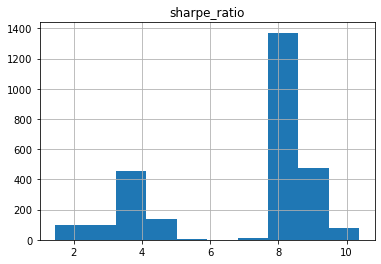

In [117]:
test.hist()

In [118]:
test.to_csv('../data/curated/final_model/3_vars.csv', index=False)